### Pulling, Preprocessing, and Splitting the Data

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# IQR Outlier clipper
def iqr_clip(df, test, column, upper = 0.75, lower = 0.25, factor = 1.5):
    mean = df[column].mean()
    iqr = df[column].quantile(upper) - df[column].quantile(lower)
    filter = (df[column] < mean+iqr*factor) & (df[column] > mean-iqr*factor)
    return df[filter],test[filter]

# Pull positive and negative reviews and combine into 1 dataframe
positive_sample = pd.read_csv(r'data\samples\positive_sample.csv', nrows = 100000)
negative_sample = pd.read_csv(r'data\samples\negative_sample.csv', nrows = 100000)
df = pd.concat([positive_sample,negative_sample], ignore_index= True)


# Keep relevant variables
df = df[['playtime','review','sentiment']]

# Replace playtime nulls with ~0 [See 8]. A miniscule constant is added for the log transform.
df.loc[df['playtime'].isna(),'playtime'] = 0.000001

# Log transform playtime data
df['playtime'] = np.log(df['playtime'])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[['playtime','review']],df['sentiment'], train_size=0.8)

# Clip playtime outliers with percentiles at 95% and 5% and a factor of 1.5 (default) 
X_train,y_train = iqr_clip(X_train, y_train, 'playtime',0.95,0.05)


##### Comparing review text as a predictor versus review text with playtime

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Extract features and vectorize training set of reviews.
vec = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_f = vec.fit_transform(X_train['review'])

# Transform test set using the training set vector
X_test_f = vec.transform(X_test['review'])

# Baseline prediction with just review text
clf_text = LogisticRegression(max_iter=400).fit(X_train_f,y_train)
y_pred = clf_text.predict(X_test_f)

# Dataframe to store accuracy results
accuracy = pd.DataFrame(columns =['Accuracy score'])

# Append results to dataframe
accuracy.loc['Text Only Logistic'] = accuracy_score(y_test,y_pred)
accuracy


,Accuracy score
Text Only Logistic,0.88475


High accuracy as seen before in (7.5). 

Next, to incorporate playtime:

#### Fitting Combined Feature Vector to Logistic Regression

In [25]:
from scipy.sparse import csr_matrix
from scipy import sparse

# Append playtime to text feature matrix. Vectorizer produces a sparse matrix so playtime is converted and horizontally stacked
combined_train = sparse.hstack((X_train_f,csr_matrix(X_train['playtime'].values.reshape(-1,1))))
combined_test = sparse.hstack((X_test_f,csr_matrix(X_test['playtime'].values.reshape(-1,1))))

# Fit a logistic regression model with the combined training data and predict results
clf_comb = LogisticRegression(max_iter=400).fit(combined_train,y_train)
y_pred_comb = clf_comb.predict(combined_test)

accuracy.loc['Text & Playtime Logistic']= accuracy_score(y_test,y_pred_comb)
accuracy

,Accuracy score
Text Only Logistic,0.88475
Text & Playtime Logistic,0.88810


Accuracy marginally increased. As seen in (8), playtime isn't the best predictor for review sentiment. With the small increase in accuracy, it may have helped push a small number of sampels to the right sentiment, but if anything it's a minor improvement.

Now to test the influence of playtime with a more complex model, a neural network. In (8), using an MLP classifer did give better results than a logistic regresion, so the expecation going into this test is that we'll observe a bigger increase in accuracy.

#### Nueral Network Test
##### Training with only the Review Text

In [26]:
from sklearn.neural_network import MLPClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# MLP Classifier. Max Iterations set low to avoid overfitting to training data
mlp_text =  MLPClassifier(hidden_layer_sizes=(30), max_iter=2, random_state=1)
clf_text_nn = mlp_text.fit(X_train_f, y_train)
y_pred_text_nn = clf_text_nn.predict(X_test_f)

accuracy.loc['Text Only NN'] = accuracy_score(y_test,y_pred_text_nn)
accuracy

,Accuracy score
Text Only Logistic,0.884750
Text & Playtime Logistic,0.888100
Text Only NN,0.885825


Text only accuracy is almost equal to the logistic regression. This shows good of a predictor the review text is.

##### Training with Text & Playtime

In [27]:

mlp_comb =  MLPClassifier(hidden_layer_sizes=(30), max_iter=2, random_state=1)
clf_comb_nn = mlp_comb.fit(combined_train, y_train)
y_pred_comb_nn = clf_comb_nn.predict(combined_test)

accuracy.loc['Text & Playtime NN'] = accuracy_score(y_test,y_pred_comb_nn)
accuracy

,Accuracy score
Text Only Logistic,0.884750
Text & Playtime Logistic,0.888100
Text Only NN,0.885825
Text & Playtime NN,0.888475


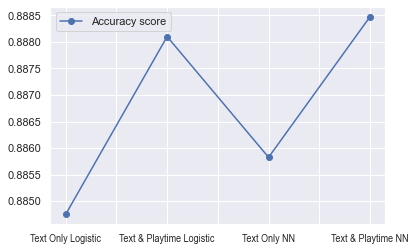

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy.plot.line(marker = 'o', )
plt.xticks(fontstretch=300)
plt.show()

We can see an improved as we include both features and move to more complex models. But don't be fooled by the graph, this improvement is over less than a percent of accuracy. Whether the value of having an extra feature for such a small gain in accuracy depends on factors like the availability of that feature in the use cases of the model and the most value we can extract from it. We're trying to answer the question of: 'Is it worth predicting our sentiment based on the review AND the playtime if playtime isn't adding a lot to our accuracy and limits our model to data that optimally has both features?' 

The same applies to using a nueral network versus a logsitc regression. We need to define an experiement that reduces these 4 model/feature approaches to one that doesn't only maximize accuracy, but also flexibility and efficiency.

In the next step we'll create pipelines that'll allow us to improve each model's accuracy by optimizing their hyper parameters. This'll give us a better look at the highest accuracy each approach can achieve.